# Comparison between TARDIS and ChiantiPy

In [1]:
from pathlib import Path

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from tardis.io.atom_data import AtomData
from tardis.io.configuration.config_reader import Configuration
from tardis.model.base import SimulationState
from tardis.plasma.equilibrium.rates import (
    RadiativeRatesSolver,
    ThermalCollisionalRateSolver,
)
from tardis.plasma.radiation_field import (
    DilutePlanckianRadiationField,
)

home = str(Path('~').expanduser())

config = Configuration.from_yaml(home+"/tardis/tardis/plasma/tests/data/plasma_base_test_config.yml")

ion_slice = (2, 0, slice(None), slice(None))


def get_radiative_rate_solver(radiative_transitions):
    rad_rate_solver = RadiativeRatesSolver(radiative_transitions)
    return rad_rate_solver

def get_chianti_collisional_rate_solver(atom_data, radiative_transitions,):
    col_strength_temperatures = atom_data.collision_data_temperatures
    col_strengths = atom_data.collision_data.loc[ion_slice, :]
    collisional_rate_solver = ThermalCollisionalRateSolver(atom_data.levels, radiative_transitions, col_strength_temperatures, col_strengths, 'chianti', "none")
    return collisional_rate_solver

chianti_atom_data = AtomData.from_hdf(home+'/carsus/docs/kurucz_cd23_chianti_H_Si.h5')

chianti_radiative_transitions = chianti_atom_data.lines.loc[ion_slice, :]

chianti_sim_state = SimulationState.from_config(config, atom_data=chianti_atom_data)

/home/afullard/tardis/tardis/__init__.py:20: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

Number of density points larger than number of shells. Assuming inner point irrelevant


In [2]:
from tardis.plasma.electron_energy_distribution import (
    ThermalElectronEnergyDistribution,
)

chianti_radiative_rate_solver = get_radiative_rate_solver(chianti_radiative_transitions)

chianti_collisional_rate_solver = get_chianti_collisional_rate_solver(chianti_atom_data, chianti_radiative_transitions)

temperature = chianti_sim_state.t_radiative

# need a better way to make a custom radiation field where the intensity is zero
# in specific locations as desired
rad_field = DilutePlanckianRadiationField(chianti_sim_state.t_radiative, dilution_factor=np.zeros_like(chianti_sim_state.t_radiative))
electron_dist = ThermalElectronEnergyDistribution(0, chianti_sim_state.t_radiative, 1e6 * u.g/u.cm**3)

In [3]:
rate_solvers = [(chianti_radiative_rate_solver, "radiative"), (chianti_collisional_rate_solver, "electron")]

lte_rate_solvers = [(chianti_collisional_rate_solver, "electron")]

In [4]:
rad_rates = chianti_radiative_rate_solver.solve(rad_field)

In [5]:
col_rates = chianti_collisional_rate_solver.solve(electron_dist.temperature)

In [6]:
from tardis.plasma.equilibrium.level_populations import LevelPopulationSolver
from tardis.plasma.equilibrium.rate_matrix import RateMatrix

rate_matrix_solver = RateMatrix(rate_solvers, chianti_atom_data.levels)

rate_matrix = rate_matrix_solver.solve(rad_field, electron_dist)

lte_rate_matrix = RateMatrix(lte_rate_solvers, chianti_atom_data.levels).solve(rad_field, electron_dist)

In [7]:
solver = LevelPopulationSolver(rate_matrix, chianti_atom_data.levels)

level_pops = solver.solve()

lte_level_pops = LevelPopulationSolver(lte_rate_matrix, chianti_atom_data.levels).solve()

/home/afullard/tardis/tardis/plasma/equilibrium/level_populations.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  normalized_level_populations.loc[species_id, :].update(
/home/afullard/tardis/tardis/plasma/equilibrium/level_populations.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [8]:
chianti_levels = [3.42881304e-01, 6.57118589e-01, 4.18696636e-09, 5.67602616e-08,
        4.63312038e-08, 1.20482595e-11, 1.97010580e-11, 3.48183541e-15,
        6.88699562e-16, 2.78695447e-16, 4.20834423e-16, 1.25473722e-15,
        2.49671361e-15, 8.92884539e-17, 1.65423100e-16, 2.11333508e-17,
        1.11695201e-17, 1.69708563e-17, 2.70670610e-17, 5.36487601e-17,
        8.72033865e-18, 1.17118808e-17, 3.44693669e-16, 5.11955673e-16,
        2.81010802e-18, 3.50318771e-18, 5.25951995e-18, 3.28532989e-18,
        6.57049588e-18]

chianti_levels_he_1 = [1.00000000e+00, 1.75073626e-11, 1.8167685e-8, 1.79805022e-19,
        1.07614011e-19, 3.58865323e-20, 8.18076407e-23, 1.76624918e-21,
        3.95823826e-22, 1.30154195e-21, 7.81338357e-22, 2.60269199e-22,
        1.83743361e-22, 1.21199070e-22, 7.93684710e-23, 7.69690651e-23,
        5.55204217e-24, 4.28655703e-23, 8.91723472e-23, 3.08213125e-22,
        1.84912140e-22, 6.16147989e-23, 5.28143670e-23, 3.77505779e-23,
        2.26343284e-23, 3.19064683e-23, 8.89209221e-24, 9.39180485e-23,
        5.19053997e-23, 2.53784273e-23, 2.27283788e-24, 1.11837286e-22,
        3.85509048e-23, 1.07725425e-22, 6.46134793e-23, 2.15124099e-23,
        2.22314242e-23, 1.59215321e-23, 9.54500244e-24, 1.48014892e-23,
        3.80078829e-23, 4.89438878e-23, 2.71814793e-23, 1.79147356e-23,
        9.80689599e-23, 7.25122090e-23, 8.04471105e-23, 1.27910690e-23,
        1.51551660e-24]

chianti_levels_o_2 = [9.50427666e-01, 2.93020096e-02, 1.96811489e-02, 3.73612176e-04,
        2.15563005e-04, 1.19850233e-18, 7.62882704e-19, 3.73304507e-19,
        6.86402347e-22, 4.51096625e-22, 1.86694313e-23, 3.93108508e-23,
        5.19716753e-23, 5.48509200e-24, 1.05025627e-23, 4.23498947e-25,
        5.73694095e-23, 2.27177963e-24, 4.53847634e-24, 6.68361893e-24,
        8.38430369e-24, 9.60077484e-25, 6.19972361e-25, 1.04127656e-24,
        1.66000813e-24, 2.48443321e-24, 6.16103282e-24, 9.08726063e-24,
        3.02895913e-24, 1.64793516e-25, 7.92929866e-26, 2.66317598e-23,
        6.44175783e-23, 5.28146898e-25, 7.36488325e-25]

## Current issues:

- Rates matrix layout is different between Chianti and TARDIS despite identical data
- Still some large % differences for high-energy lines
- He I is different for the second and third levels


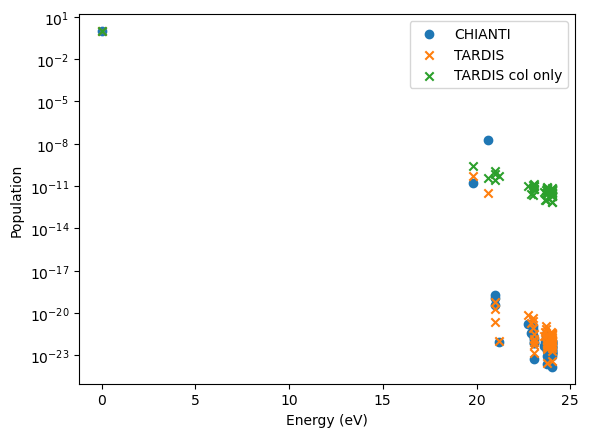

In [9]:
plt.scatter(chianti_atom_data.levels.loc[2,0].energy * u.erg.to('eV'), chianti_levels_he_1, marker='o', label='CHIANTI')
plt.scatter(chianti_atom_data.levels.loc[2,0].energy * u.erg.to('eV'), level_pops.loc[2,0,:][0], marker='x', label='TARDIS')
plt.scatter(chianti_atom_data.levels.loc[2,0].energy * u.erg.to('eV'), lte_level_pops.loc[2,0,:][0], marker='x', label='TARDIS col only')
plt.xlabel("Energy (eV)")
plt.ylabel("Population")
plt.semilogy()
plt.legend()